*Importing all the required libraries.*

In [1]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Using TensorFlow backend.


*Downloading the [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) dataset and extracting the data folder to the respective path. Commented the downloading and unzipping part from the code as the dataset is already downloaded and stored in the rooot folder.

In [0]:
# !echo "Downloading 101_Object_Categories for image notebooks"
# !curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
# !tar -xzf 101_ObjectCategories.tar.gz
# !rm 101_ObjectCategories.tar.gz
# !ls

*In the below code, we are excluding the 5 categories, which have most of the images for the [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) dataset which has 9000 labeled images belonging to the 101 categories.*

In [3]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/rhino', '101_ObjectCategories/stegosaurus', '101_ObjectCategories/metronome', '101_ObjectCategories/car_side', '101_ObjectCategories/ant', '101_ObjectCategories/mandolin', '101_ObjectCategories/beaver', '101_ObjectCategories/dolphin', '101_ObjectCategories/gerenuk', '101_ObjectCategories/cannon', '101_ObjectCategories/windsor_chair', '101_ObjectCategories/cellphone', '101_ObjectCategories/ibis', '101_ObjectCategories/strawberry', '101_ObjectCategories/crayfish', '101_ObjectCategories/joshua_tree', '101_ObjectCategories/hawksbill', '101_ObjectCategories/schooner', '101_ObjectCategories/octopus', '101_ObjectCategories/revolver', '101_ObjectCategories/dalmatian', '101_ObjectCategories/dollar_bill', '101_ObjectCategories/butterfly', '101_ObjectCategories/emu', '101_ObjectCategories/llama', '101_ObjectCategories/okapi', '101_ObjectCategories/trilobite', '101_ObjectCategories/sunflower', '101_ObjectCategories/wheelchair', '101_ObjectCategories/menorah', '101_ObjectCate

*Function to load image and return it as an input vector.*


In [0]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

*Loading all the respective images from the root folder.*

In [5]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)
print(num_classes)

97


*Shuffling the data and re-arranging it in a random order.*

In [0]:
random.shuffle(data)

*Splitting the data into train, validation and test with 0.70%,0.15% and 0.15% respectively.*

In [0]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

*Separate data for labels.*

In [0]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

*Data Pre-processing by converting the data into float32 type and keeping it normalized between 0 and 1.*

In [0]:
# Normalizing data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

*Printing a summary of overall data that we have after data pre-processing and splitting up.*

In [10]:
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


*Printing out a few of the images from our dataset.*

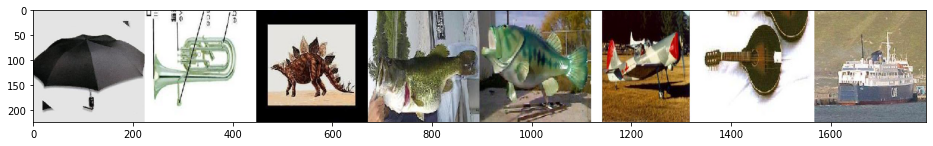

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# <center>**Task 1**</center>



# <center>*CNN Model (with dropout layer)*</center>


*First of all, we will be training a `Convolutional Neural Network`from the scratch before doing the transfer learning.
The first version (**V1**) of our CNN will consist of two convolutional layers and two max pooling layers and dropout layers. After adding two conv layers and two max pooling layers, we will add one drop out layer. After adding the dropout layer, we are adding a fully connected layer with 256 neurons, then another dropout layer, and then finally the `softmax` classification that ouput a multi class categorical probability distribution.*

In [12]:
classifier_V1 = Sequential()
print("Input dimensions: ",x_train.shape[1:])

classifier_V1.add(Conv2D(32, kernel_size=(3, 3),input_shape=x_train.shape[1:]))
classifier_V1.add(Activation('relu'))
classifier_V1.add(MaxPooling2D(pool_size=(2, 2)))

classifier_V1.add(Conv2D(32, kernel_size=(3, 3)))
classifier_V1.add(Activation('relu'))
classifier_V1.add(MaxPooling2D(pool_size=(2, 2)))

classifier_V1.add(Dropout(0.25))

classifier_V1.add(Flatten())
classifier_V1.add(Dense(256))
classifier_V1.add(Activation('relu'))

classifier_V1.add(Dropout(0.50))

classifier_V1.add(Dense(num_classes))
classifier_V1.add(Activation('softmax'))

classifier_V1.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

*Our loss function would be the general one and that is `categorical_crossentropy` and the optimizer is `Adam` which is used to update network weights.*

In [13]:
classifier_V1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_V1 = classifier_V1.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 6s 1ms/step - loss: 4.6104 - accuracy: 0.0366 - val_loss: 4.3374 - val_accuracy: 0.0677
Epoch 2/10
4346/4346 [==============================] - 4s 891us/step - loss: 4.1952 - accuracy: 0.1093 - val_loss: 3.8423 - val_accuracy: 0.1772
Epoch 3/10
4346/4346 [==============================] - 4s 888us/step - loss: 3.7144 - accuracy: 0.1917 - val_loss: 3.5157 - val_accuracy: 0.2417
Epoch 4/10
4346/4346 [==============================] - 4s 889us/step - loss: 3.0902 - accuracy: 0.3028 - val_loss: 3.1625 - val_accuracy: 0.3018
Epoch 5/10
4346/4346 [==============================] - 4s 892us/step - loss: 2.4072 - accuracy: 0.4227 - val_loss: 2.8938 - val_accuracy: 0.3545
Epoch 6/10
4346/4346 [==============================] - 4s 893us/step - loss: 1.7412 - accuracy: 0.5571 - val_loss: 2.8315 - val_accuracy: 0.3620
Epoch 7/10
4346/4346 [==============================] - 4s 892us/step - loss: 1

*Finally, we see that we have achieved an accuracy around 39% on the test set considering the fact that we only had limited images to test with and also that we provided dropout layers to this model.*



In [14]:
loss_V1, accuracy_V1 = classifier_V1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss_V1)
print('Test accuracy:', accuracy_V1)

Test loss: 3.0888985584733826
Test accuracy: 0.3851931393146515


# <center>*CNN Model (without dropout layer)*</center>


*Now, in the second part, we are building a second version(**V2**) of our CNN, that would not consist of any drop out layer and other parameters would be same as the first version above. Finally, we will test this version of CNN on the same Caltech-101 dataset and study the differences in the accuracy on the test data, if any.*

In [15]:
classifier_V2 = Sequential()
print("Input dimensions: ",x_train.shape[1:])

classifier_V2.add(Conv2D(32, kernel_size=(3, 3), input_shape=x_train.shape[1:]))
classifier_V2.add(Activation('relu'))
classifier_V2.add(MaxPooling2D(pool_size=(2, 2)))

classifier_V2.add(Conv2D(32, kernel_size=(3,3)))
classifier_V2.add(Activation('relu'))
classifier_V2.add(MaxPooling2D(pool_size=(2, 2)))

classifier_V2.add(Flatten())
classifier_V2.add(Dense(256))
classifier_V2.add(Activation('relu'))

classifier_V2.add(Dense(num_classes))
classifier_V2.add(Activation('softmax'))

classifier_V2.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_6 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)  

In [16]:
classifier_V2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_V2 = classifier_V2.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 4s 901us/step - loss: 4.8549 - accuracy: 0.0364 - val_loss: 4.4516 - val_accuracy: 0.0559
Epoch 2/10
4346/4346 [==============================] - 4s 874us/step - loss: 4.2654 - accuracy: 0.0923 - val_loss: 4.0680 - val_accuracy: 0.1375
Epoch 3/10
4346/4346 [==============================] - 4s 878us/step - loss: 3.6194 - accuracy: 0.2181 - val_loss: 3.5674 - val_accuracy: 0.2299
Epoch 4/10
4346/4346 [==============================] - 4s 879us/step - loss: 2.7221 - accuracy: 0.3833 - val_loss: 3.2774 - val_accuracy: 0.2900
Epoch 5/10
4346/4346 [==============================] - 4s 878us/step - loss: 1.6331 - accuracy: 0.6266 - val_loss: 3.0252 - val_accuracy: 0.3598
Epoch 6/10
4346/4346 [==============================] - 4s 877us/step - loss: 0.5978 - accuracy: 0.8709 - val_loss: 3.2432 - val_accuracy: 0.3588
Epoch 7/10
4346/4346 [==============================] - 4s 878us/step - loss:

*Finally, we see that we have achieved an accuracy of approximately 38% on the test set when dropout layer was not added to our CNN model Version 2.*

In [17]:
loss_V2, accuracy_V2 = classifier_V2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss_V2)
print('Test accuracy:', accuracy_V2)

Test loss: 3.9890637193114973
Test accuracy: 0.3787553608417511


*Plotting the Validation loss vs Validation accuracy for both the versions of our CNN (**with and without dropout respectively**):*

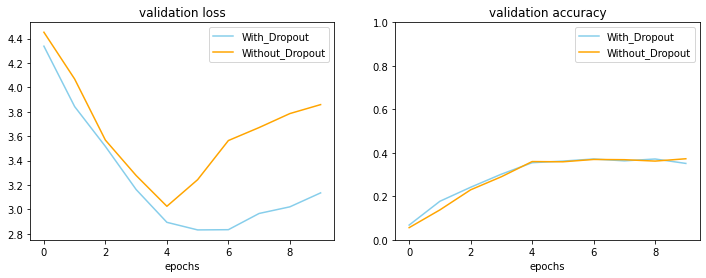

In [18]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.plot(history_V1.history["val_loss"], color = "skyblue", label = 'With_Dropout')
ax.plot(history_V2.history["val_loss"], color = "orange", label = 'Without_Dropout')
ax.set_title("validation loss")
ax.set_xlabel("epochs")
ax.legend()

ax2 = fig.add_subplot(122)
ax2.plot(history_V1.history["val_accuracy"], color = 'skyblue', label = 'With_Dropout')
ax2.plot(history_V2.history["val_accuracy"], color = 'orange', label = 'Without_Dropout')
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)
ax2.legend()

**Conclusion** - *From the results above, we can conclude that when we did not put any dropout layers in our CNN model version 2, the test accuracy is less and the test loss is high(**3.989064**) as compared to the CNN version 1 where we have dropout layers in our model, the test accuracy is higher and the test loss has dropped significantly to (**3.088899)**.*

*This change in test accuracy is expected because the dropout layers prevent the model from overfitting during training time, thus reducing the test loss.*

*We have plotted both the CNN version 1 and version 2 to compare the actual differences between the validation accuracy and validation loss and the test loss and test accuracy has been printed out using pandas dataframe.*

*By comparing the above graphs, we can say that when we added drop out layer to our CNN model, we got an accuracy of just around 39% and without drop out layer for V2, we got an accuracy of 38% respectively.*

In [19]:
import pandas as pd
table = {'' :['With_Dropout', 'Without_Dropout'], 'Test Accuracy': [accuracy_V1,accuracy_V2], 'Test Loss': [loss_V1,loss_V2]}
df = pd.DataFrame(data=table)
df

,,Test Accuracy,Test Loss
0,With_Dropout,0.385193,3.088899
1,Without_Dropout,0.378755,3.989064


# <center>**Task 2**</center>


# <center>*Transfer Learning*</center>


*Now, we will apply transfer learning to a pre-trained network (**ResNet50V2**). First of all, we will load the model ResNet50V2. Then, we will adapt this model to the Caltech-101 dataset and then re-train this model on this data. For the first retraining iteration, we will keep all the layers frozen except the last one.*

*Loading the **ResNet50V2** model via keras pretrained models and printing out the model summary for a quick look at the layers and the output shapes.*

In [0]:
ResNetV2 = keras.applications.ResNet50V2(weights='imagenet', include_top=True)

*Displaying the model summary. As the summary printed is quite lengthy, we are suppressing the output using the %%capture command. If the entire summary needs to be viewed, we can comment out the %%capture or remove that.*

In [21]:
#%%capture
ResNetV2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

*Creating a copy of the ResNetV2 from it's input layer until the second to last layer, rather than modifying the ResNetV2 object directly. Then, we create a new model, whose input layer is the same as our pre-trained model(**ResNet50V2**), but the output layer is our new softmax layer, called the `new_classification_layer`.*

In [0]:
inp = ResNetV2.input

new_classification_layer = Dense(num_classes, activation='softmax')

out = new_classification_layer(ResNetV2.layers[-2].output)

model_new = Model(inp, out)

*Now, as we have created a new model with our inputs and outputs, we will perform the first round of re-training with our ResNet50V2 on the Caltech-101 dataset by keeping all the layers frozen, just except the last layer.*

#### **First retraining** (*keeping all layers frozen except the last one*)




In [0]:
# making all layers untrainable by freezing weights (except for last layer)

for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

*Just to check that we are keeping only the last layer as trainable.*

In [24]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in model_new.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fb650076668>,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7fb650076390>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7fb664a9a390>,conv1_conv,False
3,<keras.layers.convolutional.ZeroPadding2D object at 0x7fb5ee630940>,pool1_pad,False
4,<keras.layers.pooling.MaxPooling2D object at 0x7fb5ee630dd8>,pool1_pool,False
...,...,...,...
187,<keras.layers.merge.Add object at 0x7fb5ee7bedd8>,conv5_block3_out,False
188,<keras.layers.normalization.BatchNormalization object at 0x7fb5cd446438>,post_bn,False
189,<keras.layers.core.Activation object at 0x7fb5cd446d30>,post_relu,False
190,<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fb5cd4675f8>,avg_pool,False


In [0]:
model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

*Displaying the model summary. As the summary printed is quite lengthy, we are suppressing the output using the %%capture command. If the entire summary needs to be viewed, we can comment out the %%capture or remove that.*



In [26]:
#%%capture
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

*Fitting the model on training data and validating on the validation data.*

In [27]:
history_V3 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 15s 4ms/step - loss: 2.7003 - accuracy: 0.4508 - val_loss: 0.9079 - val_accuracy: 0.7755
Epoch 2/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.6525 - accuracy: 0.8955 - val_loss: 0.5273 - val_accuracy: 0.8539
Epoch 3/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.3312 - accuracy: 0.9512 - val_loss: 0.4339 - val_accuracy: 0.8722
Epoch 4/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.2127 - accuracy: 0.9745 - val_loss: 0.3948 - val_accuracy: 0.8915
Epoch 5/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1458 - accuracy: 0.9860 - val_loss: 0.3769 - val_accuracy: 0.8926
Epoch 6/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1086 - accuracy: 0.9929 - val_loss: 0.3683 - val_accuracy: 0.8990
Epoch 7/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0825

In [28]:
loss_V3, accuracy_V3 = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss_V3)
print('Test accuracy:', accuracy_V3)

Test loss: 0.3218582281163322
Test accuracy: 0.9077253341674805


#### **Second retraining** (*Keeping all layers frozen except the last two layers*)


In [0]:
# making all layers untrainable by freezing weights (except for the last two layers).

for l, layer in enumerate(model_new.layers[:-2]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-2:]):
    layer.trainable = True

*Just to check that we are keeping only the last two layers as trainable.*

In [30]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in model_new.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fb650076668>,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7fb650076390>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7fb664a9a390>,conv1_conv,False
3,<keras.layers.convolutional.ZeroPadding2D object at 0x7fb5ee630940>,pool1_pad,False
4,<keras.layers.pooling.MaxPooling2D object at 0x7fb5ee630dd8>,pool1_pool,False
...,...,...,...
187,<keras.layers.merge.Add object at 0x7fb5ee7bedd8>,conv5_block3_out,False
188,<keras.layers.normalization.BatchNormalization object at 0x7fb5cd446438>,post_bn,False
189,<keras.layers.core.Activation object at 0x7fb5cd446d30>,post_relu,False
190,<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fb5cd4675f8>,avg_pool,True


In [0]:
model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

*Displaying the model summary. As the summary printed is quite lengthy, we are suppressing the output using the %%capture command. If the entire summary needs to be viewed, we can comment out the %%capture or remove that.*

In [32]:
#%%capture
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [33]:
history_V4 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 14s 3ms/step - loss: 0.0445 - accuracy: 0.9975 - val_loss: 0.3521 - val_accuracy: 0.9012
Epoch 2/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0216 - accuracy: 0.9993 - val_loss: 0.3663 - val_accuracy: 0.9044
Epoch 3/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.3651 - val_accuracy: 0.9066
Epoch 4/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.3627 - val_accuracy: 0.9098
Epoch 5/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.3611 - val_accuracy: 0.9098
Epoch 6/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.3720 - val_accuracy: 0.9076
Epoch 7/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0054

In [34]:
loss_V4, accuracy_V4 = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss_V4)
print('Test accuracy:', accuracy_V4)

Test loss: 0.3507730732651931
Test accuracy: 0.9109442234039307


As we can see from the results obtained above, that on applying transfer learning to the pre-trained model **ResNet50V2** for the `Caltech-101` dataset, we got an improvement of over 50% over the original CNN model trained from the scratch. (In short, in case of transfer learning we wrongly made prediction only on around 10% of the image data test set as compared to around 60% wrong prediction in case of CNN.

Using the below graphs, we are displaying the accuracy score comparison for pre-trained model with layers freezed vs unfreezed.

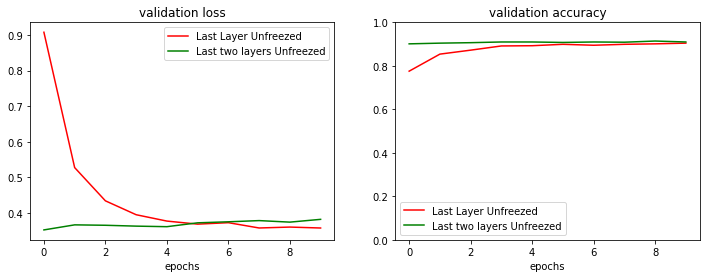

In [35]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.plot(history_V3.history["val_loss"], color = 'red', label = 'Last Layer Unfreezed')
ax.plot(history_V4.history["val_loss"], color = 'green', label = 'Last two layers Unfreezed')
ax.set_title("validation loss")
ax.set_xlabel("epochs")
ax.legend()

ax2 = fig.add_subplot(122)
ax2.plot(history_V3.history["val_accuracy"], color = 'red', label = 'Last Layer Unfreezed')
ax2.plot(history_V4.history["val_accuracy"], color = 'green', label = 'Last two layers Unfreezed')
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)
ax2.legend()

plt.show()

# <center>**Task 3**</center>


# <center>*Data Augmentation*</center>


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    zoom_range=0.20,
    shear_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [38]:
history_V5 = model_new.fit_generator(datagen.flow(x_train,y_train, batch_size=128),
        epochs = 10, 
        validation_data = (x_val,y_val))

Epoch 1/10
34/34 [==============================] - 42s 1s/step - loss: 0.2527 - accuracy: 0.9264 - val_loss: 0.4400 - val_accuracy: 0.8904
Epoch 2/10
34/34 [==============================] - 38s 1s/step - loss: 0.1615 - accuracy: 0.9524 - val_loss: 0.4300 - val_accuracy: 0.8958
Epoch 3/10
34/34 [==============================] - 39s 1s/step - loss: 0.1305 - accuracy: 0.9604 - val_loss: 0.4139 - val_accuracy: 0.9001
Epoch 4/10
34/34 [==============================] - 39s 1s/step - loss: 0.1080 - accuracy: 0.9682 - val_loss: 0.4108 - val_accuracy: 0.9012
Epoch 5/10
34/34 [==============================] - 39s 1s/step - loss: 0.1094 - accuracy: 0.9655 - val_loss: 0.4134 - val_accuracy: 0.9044
Epoch 6/10
34/34 [==============================] - 39s 1s/step - loss: 0.0976 - accuracy: 0.9733 - val_loss: 0.3839 - val_accuracy: 0.9076
Epoch 7/10
34/34 [==============================] - 39s 1s/step - loss: 0.0781 - accuracy: 0.9795 - val_loss: 0.4019 - val_accuracy: 0.9044
Epoch 8/10
34/34 [==

In [39]:
loss_V5, accuracy_V5 = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss_V5)
print('Test accuracy:', accuracy_V5)

Test loss: 0.376446856233759
Test accuracy: 0.9098712205886841


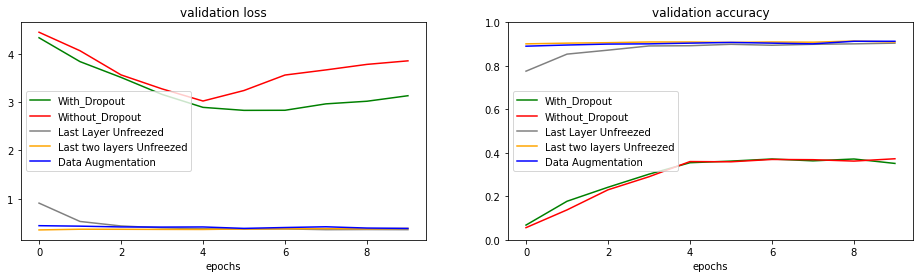

In [40]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history_V1.history["val_loss"] , color="green" , label= "With_Dropout")
ax.plot(history_V2.history["val_loss"], color="red" , label= "Without_Dropout")
ax.plot(history_V3.history["val_loss"] , color="grey" , label= "Last Layer Unfreezed")
ax.plot(history_V4.history["val_loss"], color="orange" , label= "Last two layers Unfreezed")
ax.plot(history_V5.history["val_loss"], color="blue" , label= "Data Augmentation")
ax.set_title("validation loss")
ax.set_xlabel("epochs")
ax.legend()

ax2 = fig.add_subplot(122)
ax2.plot(history_V1.history["val_accuracy"], color="green" , label= "With_Dropout")
ax2.plot(history_V2.history["val_accuracy"], color="red" , label= "Without_Dropout")
ax2.plot(history_V3.history["val_accuracy"] , color="grey" , label= "Last Layer Unfreezed")
ax2.plot(history_V4.history["val_accuracy"], color="orange" , label= "Last two layers Unfreezed")
ax2.plot(history_V5.history["val_accuracy"], color="blue" , label= "Data Augmentation")
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)
ax2.legend()

plt.show()

In [41]:
import pandas as pd
table = {'' :['With_Dropout', 
              'Without_Dropout', 
              'Last Layer Unfreezed',
              'Last two layers Unfreezed',
              'Data Augmentation'], 
         'Test Accuracy': [accuracy_V1,accuracy_V2,accuracy_V3,accuracy_V4,accuracy_V5], 
         'Test Loss': [loss_V1,loss_V2,loss_V3,loss_V4,loss_V5]}
df = pd.DataFrame(data=table)
df

,,Test Accuracy,Test Loss
0,With_Dropout,0.385193,3.088899
1,Without_Dropout,0.378755,3.989064
2,Last Layer Unfreezed,0.907725,0.321858
3,Last two layers Unfreezed,0.910944,0.350773
4,Data Augmentation,0.909871,0.376447


*We have used the most common type of Data Augmentation technique that is known as the Image data augmentation that involves creating transformed version of images in the training dataset that belong to the same class as the original image. This transformation includes a range of operations, such as horizontal_flip, zoom_range, rotation_range. We have used this data augmentation technique because it can help the model in learning the features that can be unchanged to transformations such as left to right or top to bottom.*

*As printed, the test accuracy after applying the data augmentation is over 90%.*

**Final Conclusion** - *When we built our CNN model from scratch, we observed that we got an accurcay of over 36% when we kept dropout layers in the model and even lesser accuracy when we moved out dropout layers. Dropout layers prevent overfitting of the model and thus result in less test loss and higher validation accracy which is the same case as we observed here.*

*We saw the fact that how effective can transfer learning be when we trained an already pre-trained model (**ResNet50V2**) model on our Caltech-101 dataset and achieved an improvement in accuracy of even more than 50% on the same dataset that we used to build the CNN from scratch.*

*ResNet50V2 was pre trained on 1000 classes and then we trained this model again using 97 class categories from our dataset by making just the last layer trainable at first and then making the last two layers trainable. Doing so, we could see a slight increase in accuracy from 89.2% to 90.2% indicating that our Caltech-101 dataset was not drastically different in context from the dataset which the pre-trained model was trained on and hence generalised well on this dataset.*

*Using data augmentation on the dataset with a variety of hyperparameters we can say that the accuracy achieved is more or less similar to what we achieved using transfer learning. By performing some feature engineering and tweaking, we may be able to increase the accuracy score a bit more*.